# 多目的最適化

最適化したい目的関数が複数 ($p$ 個) ある場合は、多目的最適化をおこないます。  
本チュートリアルでは、「解」は目的関数の組 $y = (y_1(x), y_2(x), \dots, y_p(x)) $ を意味することに注意してください。  
解の大小関係 $\prec$ を以下のように定義します。  

$y \prec y^{'}$ $\Longleftrightarrow$ $\forall \ i \le p$, $y_i \le y^{'}_i  \land \exists \ j \le p$, $y_j \lt y^{'}_j$ 

（最大化問題における） **パレート解** とは、上記の大小関係の上で、自身よりも大きな解がないような解を指します。  
すなわち、任意の目的関数の値を改善しようとした場合、他の目的関数のうちどれかひとつは悪化するような解です。  
目的関数間にトレードオフが存在する場合は、パレート解は複数存在するため、それらを効率的に求めることが課題となります。

PHYSBOでは、パレート解を効率的に求めるためのベイズ最適化手法を実装しています。  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import physbo
%matplotlib inline

## テスト関数

本チュートリアルでは、多目的最適化のベンチマーク関数である VLMOP2 を利用します。  
目的関数の数は2つです。

$$
\begin{split}
    y_1(\vec{x}) &= 1 - \exp\left[-\sum_{i=1}^N\left( x_i - 1/\sqrt{N}\right)^2\right] \\
    y_2(\vec{x}) &= 1 - \exp\left[-\sum_{i=1}^N\left( x_i + 1/\sqrt{N}\right)^2\right]
\end{split}
$$

$y_1$ と $y_2$ はそれぞれ $x_1 = x_2 = \cdots x_N = 1/\sqrt{N}$ と $x_1 = x_2 = \cdots x_N = -1/\sqrt{N}$ に最小値があり、その値はともに０です。また、上界は1 です。

PHYSBO は最大化問題を仮定するため、-1を掛けたものをあらためて目的関数とします。

- 参考文献
    - Van Veldhuizen, David A. Multiobjective evolutionary algorithms: classifications, analyses, and new innovations. No. AFIT/DS/ENG/99-01. AIR FORCE INST OF TECH WRIGHT-PATTERSONAFB OH SCHOOL OF ENGINEERING, 1999.

In [2]:
def vlmop2_minus(x):
    n = x.shape[1]
    y1 = 1 - np.exp(-1 * np.sum((x - 1/np.sqrt(n)) ** 2, axis = 1))
    y2 = 1 - np.exp(-1 * np.sum((x + 1/np.sqrt(n)) ** 2, axis = 1))

    return np.c_[-y1, -y2]

## 探索候補データの準備

入力空間 $\vec{x}$ は 2次元とし、[-2, 2] × [-2, 2] の上で候補点をグリッド状に生成します。

In [3]:
import itertools
a = np.linspace(-2,2,101)
test_X = np.array(list(itertools.product(a, a)))

In [4]:
test_X

array([[-2.  , -2.  ],
       [-2.  , -1.96],
       [-2.  , -1.92],
       ...,
       [ 2.  ,  1.92],
       [ 2.  ,  1.96],
       [ 2.  ,  2.  ]])

In [5]:
test_X.shape

(10201, 2)

## simulator の定義

In [6]:
class simlator(object):
    def __init__(self, X):
        self.t = vlmop2_minus(X)
    
    def __call__( self, action):
        return self.t[action]

In [7]:
simu = simlator(test_X)

## 関数のプロット

2つの目的関数をそれぞれプロットしてみましょう。  
1つ目の目的関数は右上にピークがあり、2つ目の目的関数は左下にピークがあるようなトレードオフがある状態となっています。
（星はピークの位置です）

### 1つ目の目的関数

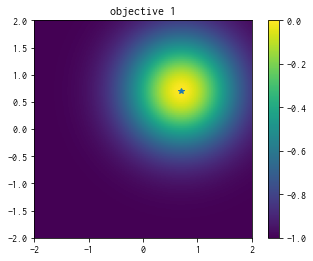

In [8]:
plt.figure()
plt.imshow(simu.t[:,0].reshape((101,101)), vmin=-1.0, vmax=0.0, origin="lower", extent=[-2.0, 2.0, -2.0, 2.0])
plt.title("objective 1")
plt.colorbar()
plt.plot([1.0/np.sqrt(2.0)], [1.0/np.sqrt(2.0)], '*')
plt.show()

### 2つ目の目的関数

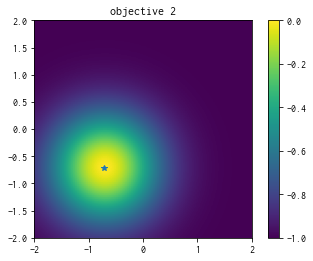

In [9]:
# plot objective 2
plt.figure()
plt.imshow(simu.t[:,1].reshape((101,101)), vmin=-1.0, vmax=0.0, origin="lower", extent=[-2.0, 2.0, -2.0, 2.0])
plt.title("objective 2")
plt.colorbar()
plt.plot([-1.0/np.sqrt(2.0)], [-1.0/np.sqrt(2.0)], '*')
plt.show()

## 最適化の実行

### policy のセット

多目的最適化用の `policy_mo` を利用します。  
`num_objectives` に目的関数の数を指定してください。

In [10]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)

通常の `policy` (目的関数が1つの場合）と同じく、`random_search` または `bayes_search` メソッドを呼ぶことで最適化を行います。  
基本的なAPIや利用方法は `policy` とおおよそ共通しています。

### ランダムサーチ

In [11]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)

res_random = policy.random_search(max_num_probes=50, simulator=simu)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

目的関数の評価値(の array) とそのときの action ID が表示されます。  
また、パレート解集合 (Pareto set) が更新されたときにメッセージを表示します。

Pareto set が更新された際に中身を表示したい場合は、`disp_pareto_set=True` と指定します。  
Pareto set は1つ目の目的関数値の昇順でソートされています。また、steps はパレート解が追加された際のステップ数を示しています。

In [12]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)
res_random = policy.random_search(max_num_probes=50, simulator=simu, disp_pareto_set=True)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   current Pareto set = [[-0.99973003 -0.62334035]] (steps = [1]) 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   current Pareto set = [[-0.99973003 -0.62334035]
 [-0.99789981 -0.99866427]] (steps = [1 2]) 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   current Pareto set = [[-0.99090897 -0.46609239]] (steps = [3]) 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   current Pareto set = [[-0.92633083 -0.29208351]] (steps = [4]) 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   current Pareto set = [[-0.92633083 -0.29208351]
 [-0.67969326 -0.99981691]] (steps = [4 5]) 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   current Pareto set = [[-0.92633083 -0.29208351]
 [-0.45601619 -0.99848443]] (steps =

### 結果の確認

 #### 評価値の履歴

In [13]:
res_random.fx[0:res_random.num_runs]

array([[-0.99973003, -0.62334035],
       [-0.99789981, -0.99866427],
       [-0.99090897, -0.46609239],
       [-0.92633083, -0.29208351],
       [-0.67969326, -0.99981691],
       [-0.45601619, -0.99848443],
       [-0.92670204, -0.71508873],
       [-0.58233995, -0.99952931],
       [-0.99848229, -0.96780195],
       [-0.80479332, -0.99994946],
       [-0.99700074, -0.99847873],
       [-0.9992592 , -0.93891121],
       [-0.19963873, -0.93357674],
       [-0.98046765, -0.99294428],
       [-0.99602549, -0.98620358],
       [-0.99957128, -0.9973798 ],
       [-0.52191048, -0.72845916],
       [-0.99916441, -0.40869572],
       [-0.99480122, -0.7565076 ],
       [-0.63329589, -0.63329589],
       [-0.95437918, -0.80142908],
       [-0.99899466, -0.96646532],
       [-0.19473522, -0.99445365],
       [-0.99969529, -0.52395588],
       [-0.59106078, -0.79258035],
       [-0.78231041, -0.99997141],
       [-0.99955573, -0.99930147],
       [-0.99825097, -0.99875436],
       [-0.65387719,

#### パレート解の取得

In [14]:
front, front_num = res_random.export_pareto_front()
front, front_num

(array([[-0.95713719, -0.09067194],
        [-0.92633083, -0.29208351],
        [-0.63329589, -0.63329589],
        [-0.52191048, -0.72845916],
        [-0.26132949, -0.87913689],
        [-0.17190645, -0.91382463]]),
 array([40,  3, 19, 16, 29, 41]))

#### 解（評価値）のプロット

これ以降、図示する空間が $y = (y_1, y_2)$ であり $x = (x_1, x_2)$ ではないことにあらためて注意してください。

赤のプロットがパレート解です。

In [15]:
def plot_pareto_front(res):
    front, front_num = res.export_pareto_front()
    dominated = [i for i in range(res.num_runs) if i not in front_num]
    points = res.fx[dominated, :]

    plt.figure(figsize=(7, 7))
    plt.scatter(res.fx[dominated,0], res.fx[dominated,1], c = "blue")
    plt.scatter(front[:, 0], front[:, 1], c = "red")
    plt.title('Pareto front')
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.xlim([-1.0,0.0])
    plt.ylim([-1.0,0.0])

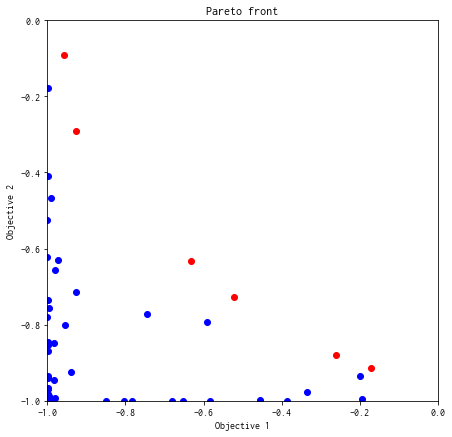

In [16]:
plot_pareto_front(res_random)

#### 劣解領域 (dominated region) の体積を計算

パレート解ではない解、すなわち、「自らよりも優れた解 $y'$ が存在する解 $y$ 」 を劣解と呼びます ($\exists y' y \prec y'$)。  
解空間（の部分空間）のうち、劣解の占める空間である劣解領域の体積は、多目的最適化の結果を示す指標のひとつです。  
この値が大きいほど、より良いパレート解が多く求まっていることになります。

`res_random.pareto.volume_in_dominance(ref_min, ref_max)` は、
`ref_min`, `ref_max` で指定された矩形(hyper-rectangle) 中の劣解領域体積を計算します。

In [17]:
res_random.pareto.volume_in_dominance([-1,-1],[0,0])

0.2376881844865093

## ベイズ最適化

多目的の場合の `bayes_search` では、`score` には以下のいずれかを指定します。

- HVPI (Hypervolume-based Probability of Improvement)
- EHVI (Expected Hyper-Volume Improvement)
- TS (Thompson Sampling)

以下、score を変えてそれぞれ 50回 (ランダムサーチ10回 + ベイズ最適化 40回) 評価を行います。

### HVPI (Hypervolume-based Probability of Improvement)

多次元の目的関数空間における非劣解領域 (non-dominated region) の改善確率を score として求めます。  

- 参考文献
    - Couckuyt, Ivo, Dirk Deschrijver, and Tom Dhaene. "Fast calculation of multiobjective probability of improvement and expected improvement criteria for Pareto optimization." Journal of Global Optimization 60.3 (2014): 575-594.

In [18]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)

policy.random_search(max_num_probes=10, simulator=simu)
res_HVPI = policy.bayes_search(max_num_probes=40, simulator=simu, score='HVPI', interval=10)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

0038-th step: f(x) = [-0.35362632 -0.83371008] (action = 5712)
   Pareto set updated.
   the number of Pareto frontiers = 27 

0039-th step: f(x) = [-0.25896196 -0.87874951] (action = 5916)
   Pareto set updated.
   the number of Pareto frontiers = 28 

0040-th step: f(x) = [-0.06762287 -0.95078624] (action = 6426)
   Pareto set updated.
   the number of Pareto frontiers = 29 

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood -68.14422496160626
50 -th epoch marginal likelihood -69.74821313678454
100 -th epoch marginal likelihood -71.16364516263106
150 -th epoch marginal likelihood -72.45633416637565
200 -th epoch marginal likelihood -73.70427277891362
250 -th epoch marginal likelihood -74.93918231618832
300 -th epoch marginal likelihood -76.16638542804964
350 -th epoch marginal likelihood -77.38658583568828
400 -th epoch marginal likelihood -78.60006687735122
450 -th epoch marginal likelihood -79.80705478031916

#### パレート解のプロット

ランダムサンプリングと比較して、パレート解が多く求まっていることが分かります。

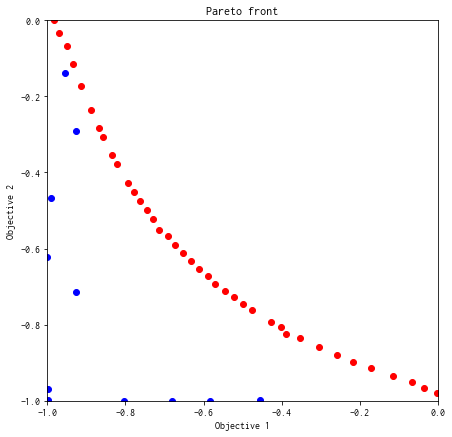

In [19]:
plot_pareto_front(res_HVPI)

#### 劣解領域体積

In [20]:
res_HVPI.pareto.volume_in_dominance([-1,-1],[0,0])

0.32877907991633726

### EHVI (Expected Hyper-Volume Improvement)

多次元の目的関数空間における非劣解領域 (non-dominated region) の改善期待値を score として求めます。  

- 参考文献
    - Couckuyt, Ivo, Dirk Deschrijver, and Tom Dhaene. "Fast calculation of multiobjective probability of improvement and expected improvement criteria for Pareto optimization." Journal of Global Optimization 60.3 (2014): 575-594.

In [21]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)

policy.random_search(max_num_probes=10, simulator=simu)
res_EHVI = policy.bayes_search(max_num_probes=40, simulator=simu, score='EHVI', interval=10)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

0037-th step: f(x) = [-0.49811725 -0.7454381 ] (action = 5406)
   Pareto set updated.
   the number of Pareto frontiers = 21 

0038-th step: f(x) = [-9.00606888e-04 -9.80950206e-01] (action = 6835)
   Pareto set updated.
   the number of Pareto frontiers = 22 

0039-th step: f(x) = [-0.98483911 -0.00295954] (action = 3263)
0040-th step: f(x) = [-0.00557976 -0.98649648] (action = 7038)
Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood -60.35218224451246
50 -th epoch marginal likelihood -62.31324230703655
100 -th epoch marginal likelihood -64.03507521142396
150 -th epoch marginal likelihood -65.58859324220901
200 -th epoch marginal likelihood -66.99580206729127
250 -th epoch marginal likelihood -68.30020077573663
300 -th epoch marginal likelihood -69.54647337575281
350 -th epoch marginal likelihood -70.7618409294369
400 -th epoch marginal likelihood -71.95882264318016
450 -th epoch marginal likelihood -73.14338125

#### パレート解のプロット

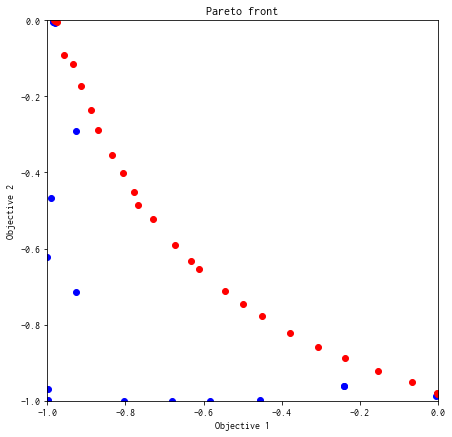

In [22]:
plot_pareto_front(res_EHVI)

#### 劣解領域体積

In [23]:
res_EHVI.pareto.volume_in_dominance([-1,-1],[0,0])

0.3200467412741881

### TS (Thompson Sampling)

単目的の場合の Thompson Sampling では、各候補(test_X)について、目的関数の事後分布からサンプリングを行い、値が最大となる候補を次の探索点として推薦します。  
多目的の場合は、サンプリングした値についてパレートルールの上で最大となる候補、つまりパレート最適な候補の中からランダムに1つ選択して次の探索点とします。

- 参考文献
    - Yahyaa, Saba Q., and Bernard Manderick. "Thompson sampling for multi-objective multi-armed bandits problem." Proc. Eur. Symp. Artif. Neural Netw., Comput. Intell. Mach. Learn.. 2015.

In [24]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)

policy.random_search(max_num_probes=10, simulator=simu)
res_TS = policy.bayes_search(max_num_probes=40, simulator=simu, score='TS', interval=10, num_rand_basis=5000)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

450 -th epoch marginal likelihood -69.80850190860637
500 -th epoch marginal likelihood -70.4462487503116
Done

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood -46.614138208164384
50 -th epoch marginal likelihood -48.14999941208065
100 -th epoch marginal likelihood -49.57886424469417
150 -th epoch marginal likelihood -50.8820560401331
200 -th epoch marginal likelihood -52.05533619926354
250 -th epoch marginal likelihood -53.11693549156229
300 -th epoch marginal likelihood -54.09625721870212
350 -th epoch marginal likelihood -55.017361293376425
400 -th epoch marginal likelihood -55.89365983770457
450 -th epoch marginal likelihood -56.73271757611425
500 -th epoch marginal likelihood -57.54052768605143
Done

0041-th step: f(x) = [-0.99938407 -0.98833098] (action = 7474)
0042-th step: f(x) = [-0.99615554 -0.21626044] (action = 2053)
0043-th step: f(x) = [-0.99164248 -0.68782977] (action = 5368)
0044-th step: f(x) =

#### パレート解のプロット

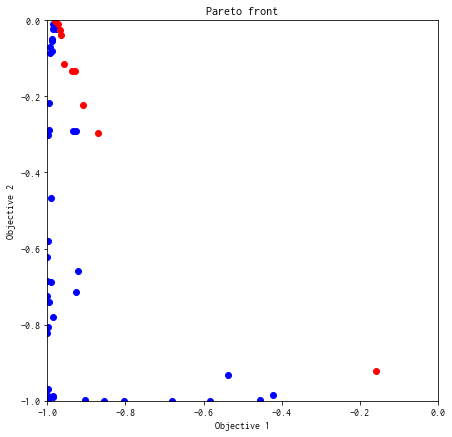

In [25]:
plot_pareto_front(res_TS)

#### 劣解領域体積

In [26]:
res_TS.pareto.volume_in_dominance([-1,-1],[0,0])

0.16415446221006114

## 付録：全探索

`random_search` で `max_num_probes` に全データ数 (`N = test_X.shape[0]`) を渡すと手軽に全探索できます。

In [27]:
policy = physbo.search.discrete.policy_mo(test_X=test_X, num_objectives=2)
policy.set_seed(0)

N = test_X.shape[0]
res_all = policy.random_search(max_num_probes=N, simulator=simu)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

0172-th step: f(x) = [-0.99773713 -0.94624297] (action = 6672)
0173-th step: f(x) = [-0.99230419 -0.10892013] (action = 2458)
0174-th step: f(x) = [-0.98910851 -0.10185777] (action = 2561)
0175-th step: f(x) = [-0.56940264 -0.9996544 ] (action = 9163)
0176-th step: f(x) = [-0.99385212 -0.20288209] (action = 2157)
0177-th step: f(x) = [-0.70182148 -0.7622028 ] (action = 4202)
0178-th step: f(x) = [-0.92827443 -0.13574902] (action = 4078)
   Pareto set updated.
   the number of Pareto frontiers = 14 

0179-th step: f(x) = [-0.73976457 -0.70859215] (action = 5999)
0180-th step: f(x) = [-0.90328237 -0.52859628] (action = 5486)
0181-th step: f(x) = [-0.87430751 -0.65204535] (action = 3391)
0182-th step: f(x) = [-0.43278935 -0.99919846] (action = 8758)
0183-th step: f(x) = [-0.69256514 -0.97448549] (action = 4422)
0184-th step: f(x) = [-0.47122787 -0.93838207] (action = 4919)
0185-th step: f(x) = [-0.98861354 -0.46669914] (action = 4766)
0186-th step: f(x) = [-0.70609636 -0.95191075] (action

0303-th step: f(x) = [-0.77049828 -0.9998531 ] (action = 9965)
0304-th step: f(x) = [-0.91908164 -0.97389649] (action = 3110)
0305-th step: f(x) = [-0.94655471 -0.67336218] (action = 2684)
0306-th step: f(x) = [-0.99946018 -0.46362348] (action = 2539)
0307-th step: f(x) = [-0.99858957 -0.63945605] (action = 951)
0308-th step: f(x) = [-0.98997801 -0.17355908] (action = 3861)
0309-th step: f(x) = [-0.99372275 -0.97560013] (action = 7688)
0310-th step: f(x) = [-0.66375246 -0.99982836] (action = 7567)
0311-th step: f(x) = [-0.83678471 -0.99997857] (action = 8179)
0312-th step: f(x) = [-0.47924892 -0.81188784] (action = 6109)
   Pareto set updated.
   the number of Pareto frontiers = 17 

0313-th step: f(x) = [-0.99973133 -0.99952697] (action = 195)
0314-th step: f(x) = [-0.25138824 -0.89061322] (action = 5717)
   Pareto set updated.
   the number of Pareto frontiers = 18 

0315-th step: f(x) = [-0.99681335 -0.48191481] (action = 4155)
0316-th step: f(x) = [-0.72237099 -0.99407237] (action 

0469-th step: f(x) = [-0.99880781 -0.57208718] (action = 3848)
0470-th step: f(x) = [-0.99945405 -0.613655  ] (action = 3442)
0471-th step: f(x) = [-0.99990413 -0.81218684] (action = 3333)
0472-th step: f(x) = [-0.9992592  -0.93891121] (action = 161)
0473-th step: f(x) = [-0.89244376 -0.99957924] (action = 10149)
0474-th step: f(x) = [-0.99786226 -0.84257331] (action = 762)
0475-th step: f(x) = [-0.99177927 -0.94975797] (action = 7184)
0476-th step: f(x) = [-0.98963613 -0.99892149] (action = 2420)
0477-th step: f(x) = [-0.99892828 -0.75534591] (action = 652)
0478-th step: f(x) = [-0.99723861 -0.99874921] (action = 9507)
0479-th step: f(x) = [-0.76500975 -0.53670383] (action = 5294)
   Pareto set updated.
   the number of Pareto frontiers = 32 

0480-th step: f(x) = [-0.81114064 -0.9985434 ] (action = 9543)
0481-th step: f(x) = [-0.90855624 -0.99999654] (action = 9790)
0482-th step: f(x) = [-0.87181675 -0.90870923] (action = 3303)
0483-th step: f(x) = [-0.99651317 -0.85415897] (action =

0641-th step: f(x) = [-0.4838299  -0.99948052] (action = 8861)
0642-th step: f(x) = [-0.99919521 -0.96230657] (action = 6566)
0643-th step: f(x) = [-0.99974852 -0.60711752] (action = 2635)
0644-th step: f(x) = [-0.32517286 -0.99850062] (action = 8454)
0645-th step: f(x) = [-0.81914475 -0.99804143] (action = 9440)
0646-th step: f(x) = [-0.82846164 -0.57592784] (action = 5592)
0647-th step: f(x) = [-0.50450041 -0.74867573] (action = 5606)
   Pareto set updated.
   the number of Pareto frontiers = 36 

0648-th step: f(x) = [-0.99999899 -0.94742002] (action = 304)
0649-th step: f(x) = [-0.99998163 -0.84334614] (action = 1920)
0650-th step: f(x) = [-0.99952697 -0.99973133] (action = 10005)
0651-th step: f(x) = [-0.62105741 -0.99984573] (action = 8169)
0652-th step: f(x) = [-0.99902034 -0.55908303] (action = 3646)
0653-th step: f(x) = [-0.82244565 -0.99912905] (action = 5247)
0654-th step: f(x) = [-0.80014423 -0.99995873] (action = 7875)
0655-th step: f(x) = [-0.5159637  -0.99342713] (action

0840-th step: f(x) = [-0.48977374 -0.99027153] (action = 8335)
0841-th step: f(x) = [-0.00295954 -0.98483911] (action = 7037)
0842-th step: f(x) = [-0.9988062  -0.82667453] (action = 556)
0843-th step: f(x) = [-0.41721105 -0.99884363] (action = 7055)
0844-th step: f(x) = [-0.88701026 -0.99877638] (action = 9740)
0845-th step: f(x) = [-0.89903802 -0.80094791] (action = 3094)
0846-th step: f(x) = [-0.99429484 -0.0724565 ] (action = 2755)
0847-th step: f(x) = [-0.86088772 -0.99999073] (action = 9485)
0848-th step: f(x) = [-0.89729291 -0.83851222] (action = 6696)
0849-th step: f(x) = [-0.13974052 -0.99257037] (action = 7842)
0850-th step: f(x) = [-0.23644203 -0.9003642 ] (action = 5718)
0851-th step: f(x) = [-0.96595101 -0.99774644] (action = 3124)
0852-th step: f(x) = [-0.99959633 -0.64180848] (action = 740)
0853-th step: f(x) = [-0.99964967 -0.80229151] (action = 244)
0854-th step: f(x) = [-0.76461227 -0.99796707] (action = 5142)
0855-th step: f(x) = [-0.99676358 -0.91390572] (action = 6

1051-th step: f(x) = [-0.81674661 -0.43193224] (action = 4990)
   Pareto set updated.
   the number of Pareto frontiers = 42 

1052-th step: f(x) = [-0.62526275 -0.99925645] (action = 9355)
1053-th step: f(x) = [-0.94022168 -0.99775284] (action = 3629)
1054-th step: f(x) = [-0.99454444 -0.87039719] (action = 1172)
1055-th step: f(x) = [-0.5059469  -0.98142777] (action = 5129)
1056-th step: f(x) = [-0.95199271 -0.58802709] (action = 2681)
1057-th step: f(x) = [-0.92913715 -0.98371956] (action = 3113)
1058-th step: f(x) = [-0.72885118 -0.99969442] (action = 9760)
1059-th step: f(x) = [-0.99999238 -0.87192066] (action = 614)
1060-th step: f(x) = [-0.99999395 -0.88615721] (action = 1013)
1061-th step: f(x) = [-0.9952275  -0.98520572] (action = 7990)
1062-th step: f(x) = [-0.92175727 -0.15807186] (action = 4179)
   Pareto set updated.
   the number of Pareto frontiers = 43 

1063-th step: f(x) = [-0.80356256 -0.6127128 ] (action = 5694)
1064-th step: f(x) = [-0.99003984 -0.58340389] (action

1241-th step: f(x) = [-0.93373833 -0.99777557] (action = 3730)
1242-th step: f(x) = [-0.76936607 -0.98290683] (action = 8323)
1243-th step: f(x) = [-0.98917271 -0.96643645] (action = 7590)
1244-th step: f(x) = [-0.9990713  -0.99940934] (action = 904)
1245-th step: f(x) = [-0.82037724 -0.99995349] (action = 7473)
1246-th step: f(x) = [-0.96646532 -0.99899466] (action = 9931)
1247-th step: f(x) = [-0.78542801 -0.99906006] (action = 9648)
1248-th step: f(x) = [-0.99553572 -0.4211736 ] (action = 4157)
1249-th step: f(x) = [-0.86989734 -0.88381465] (action = 7001)
1250-th step: f(x) = [-0.99172824 -0.90033015] (action = 1378)
1251-th step: f(x) = [-0.9999838  -0.82681234] (action = 1118)
1252-th step: f(x) = [-0.99852798 -0.6999117 ] (action = 4553)
1253-th step: f(x) = [-0.91331633 -0.99916168] (action = 9941)
1254-th step: f(x) = [-0.99877664 -0.77728159] (action = 654)
1255-th step: f(x) = [-0.36470169 -0.94095996] (action = 7121)
1256-th step: f(x) = [-0.98630317 -0.94038267] (action = 

1436-th step: f(x) = [-0.984861   -0.99936273] (action = 2928)
1437-th step: f(x) = [-0.99497924 -0.58597414] (action = 4761)
1438-th step: f(x) = [-0.99951325 -0.91138437] (action = 54)
1439-th step: f(x) = [-0.99809025 -0.68951373] (action = 955)
1440-th step: f(x) = [-0.99930251 -0.99968407] (action = 10007)
1441-th step: f(x) = [-0.82244565 -0.99912905] (action = 9747)
1442-th step: f(x) = [-0.79639583 -0.94761958] (action = 7612)
1443-th step: f(x) = [-0.96450933 -0.88998236] (action = 6890)
1444-th step: f(x) = [-0.99919892 -0.36520679] (action = 2241)
1445-th step: f(x) = [-0.70776259 -0.85177313] (action = 6706)
1446-th step: f(x) = [-0.99482304 -0.99350851] (action = 1398)
1447-th step: f(x) = [-0.99960468 -0.50746109] (action = 1337)
1448-th step: f(x) = [-0.11680268 -0.97635476] (action = 7332)
1449-th step: f(x) = [-0.99669355 -0.61715352] (action = 1258)
1450-th step: f(x) = [-0.99991674 -0.67841597] (action = 1327)
1451-th step: f(x) = [-0.99474134 -0.39111217] (action = 

1616-th step: f(x) = [-0.40645391 -0.87822249] (action = 6514)
1617-th step: f(x) = [-0.63662222 -0.98634006] (action = 4829)
1618-th step: f(x) = [-0.95968853 -0.04235756] (action = 3672)
   Pareto set updated.
   the number of Pareto frontiers = 50 

1619-th step: f(x) = [-0.99918652 -0.96961501] (action = 6768)
1620-th step: f(x) = [-0.98875434 -0.07265243] (action = 2661)
1621-th step: f(x) = [-0.75994402 -0.913284  ] (action = 3909)
1622-th step: f(x) = [-0.08294372 -0.9457967 ] (action = 6325)
   Pareto set updated.
   the number of Pareto frontiers = 50 

1623-th step: f(x) = [-0.55542968 -0.99755804] (action = 8946)
1624-th step: f(x) = [-0.99588544 -0.98400657] (action = 1088)
1625-th step: f(x) = [-0.99511003 -0.99452428] (action = 1399)
1626-th step: f(x) = [-0.44983121 -0.99890836] (action = 6955)
1627-th step: f(x) = [-0.99552904 -0.18604243] (action = 2154)
1628-th step: f(x) = [-0.99304736 -0.94671851] (action = 7082)
1629-th step: f(x) = [-0.40582663 -0.99590757] (actio

1805-th step: f(x) = [-0.79231728 -0.99302802] (action = 8830)
1806-th step: f(x) = [-0.99958672 -0.70753917] (action = 3742)
1807-th step: f(x) = [-0.9993553  -0.86856969] (action = 253)
1808-th step: f(x) = [-0.97485292 -0.57454089] (action = 2275)
1809-th step: f(x) = [-0.92951831 -0.39516386] (action = 5081)
1810-th step: f(x) = [-0.58594714 -0.99926632] (action = 9256)
1811-th step: f(x) = [-0.86572347 -0.53389579] (action = 3589)
1812-th step: f(x) = [-0.87531407 -0.92918205] (action = 7405)
1813-th step: f(x) = [-0.1136553  -0.95822055] (action = 6027)
1814-th step: f(x) = [-0.94095996 -0.36470169] (action = 4979)
1815-th step: f(x) = [-0.99258254 -0.82379035] (action = 5972)
1816-th step: f(x) = [-0.99528851 -0.90004642] (action = 1073)
1817-th step: f(x) = [-0.91875366 -0.99826532] (action = 4034)
1818-th step: f(x) = [-0.92022365 -0.56459205] (action = 3085)
1819-th step: f(x) = [-0.57375236 -0.9377169 ] (action = 4617)
1820-th step: f(x) = [-0.1603523 -0.9970667] (action = 7

1999-th step: f(x) = [-0.99988988 -0.6608231 ] (action = 1029)
2000-th step: f(x) = [-0.99747687 -0.99124163] (action = 8189)
2001-th step: f(x) = [-0.99411362 -0.99810111] (action = 1810)
2002-th step: f(x) = [-0.99649556 -0.99777116] (action = 9204)
2003-th step: f(x) = [-0.99743705 -0.17848438] (action = 2449)
2004-th step: f(x) = [-0.80333906 -0.69078728] (action = 3796)
2005-th step: f(x) = [-0.75623057 -0.99584926] (action = 4836)
2006-th step: f(x) = [-0.55457668 -0.99911619] (action = 6655)
2007-th step: f(x) = [-0.91908818 -0.99890127] (action = 4238)
2008-th step: f(x) = [-0.77136154 -0.99983612] (action = 6764)
2009-th step: f(x) = [-0.94624297 -0.99773713] (action = 9528)
2010-th step: f(x) = [-0.99213714 -0.42096676] (action = 1862)
2011-th step: f(x) = [-0.98262861 -0.18638627] (action = 4166)
2012-th step: f(x) = [-0.99998406 -0.82956129] (action = 618)
2013-th step: f(x) = [-0.5325689  -0.92351776] (action = 4716)
2014-th step: f(x) = [-0.45178484 -0.99938218] (action =

2187-th step: f(x) = [-0.1997034  -0.99720417] (action = 8050)
2188-th step: f(x) = [-0.16877986 -0.9227524 ] (action = 6421)
2189-th step: f(x) = [-0.6280523  -0.99986478] (action = 8970)
2190-th step: f(x) = [-0.99846086 -0.38138195] (action = 3247)
2191-th step: f(x) = [-0.8071257  -0.99997738] (action = 9580)
2192-th step: f(x) = [-0.38124161 -0.8730497 ] (action = 6414)
2193-th step: f(x) = [-0.73405962 -0.90393372] (action = 7109)
2194-th step: f(x) = [-0.49269945 -0.79479552] (action = 5008)
2195-th step: f(x) = [-0.96106068 -0.17390818] (action = 3073)
2196-th step: f(x) = [-0.25335559 -0.90257123] (action = 5618)
2197-th step: f(x) = [-0.98622418 -0.99717362] (action = 9314)
2198-th step: f(x) = [-0.91981439 -0.84190968] (action = 6694)
2199-th step: f(x) = [-0.99911784 -0.99889384] (action = 9298)
2200-th step: f(x) = [-0.99990017 -0.7547729 ] (action = 331)
2201-th step: f(x) = [-0.97925503 -0.9916086 ] (action = 2308)
2202-th step: f(x) = [-0.99568614 -0.12056753] (action =

2379-th step: f(x) = [-0.99949228 -0.91745532] (action = 55)
2380-th step: f(x) = [-0.9213009  -0.99416731] (action = 9023)
2381-th step: f(x) = [-0.99997065 -0.80044266] (action = 1822)
2382-th step: f(x) = [-0.97033437 -0.99612897] (action = 2818)
2383-th step: f(x) = [-0.88792973 -0.98833743] (action = 8620)
2384-th step: f(x) = [-0.31365364 -0.99760226] (action = 6850)
2385-th step: f(x) = [-0.85565328 -0.81900084] (action = 6598)
2386-th step: f(x) = [-0.73684828 -0.99962813] (action = 6358)
2387-th step: f(x) = [-0.96660505 -0.29153127] (action = 2773)
2388-th step: f(x) = [-0.99945568 -0.80462525] (action = 348)
2389-th step: f(x) = [-0.84986831 -0.9999888 ] (action = 9484)
2390-th step: f(x) = [-0.99863709 -0.45221218] (action = 1347)
2391-th step: f(x) = [-0.99602549 -0.98620358] (action = 1089)
2392-th step: f(x) = [-0.99298827 -0.93262149] (action = 1280)
2393-th step: f(x) = [-0.96780195 -0.99848229] (action = 3227)
2394-th step: f(x) = [-0.97284992 -0.99918606] (action = 3

2564-th step: f(x) = [-0.25043875 -0.99813507] (action = 8153)
2565-th step: f(x) = [-0.86412378 -0.99998865] (action = 8583)
2566-th step: f(x) = [-0.77791382 -0.9978522 ] (action = 9341)
2567-th step: f(x) = [-0.369615   -0.99910919] (action = 7658)
2568-th step: f(x) = [-0.99048981 -0.95860557] (action = 1487)
2569-th step: f(x) = [-0.87337507 -0.91946587] (action = 7304)
2570-th step: f(x) = [-0.79837052 -0.98505646] (action = 8423)
2571-th step: f(x) = [-0.99988261 -0.63840609] (action = 1529)
2572-th step: f(x) = [-0.33284627 -0.90251583] (action = 5317)
2573-th step: f(x) = [-0.92838732 -0.97413118] (action = 3009)
2574-th step: f(x) = [-0.64661672 -0.99987153] (action = 8170)
2575-th step: f(x) = [-0.9978792  -0.23878222] (action = 2848)
2576-th step: f(x) = [-0.42783895 -0.91639611] (action = 5017)
2577-th step: f(x) = [-0.99684025 -0.9974801 ] (action = 9102)
2578-th step: f(x) = [-0.99991433 -0.81208003] (action = 3232)
2579-th step: f(x) = [-0.46220179 -0.90146349] (action 

2765-th step: f(x) = [-0.72237099 -0.99407237] (action = 4834)
2766-th step: f(x) = [-0.99640925 -0.86587816] (action = 968)
2767-th step: f(x) = [-0.96170053 -0.09015481] (action = 4072)
2768-th step: f(x) = [-0.90201573 -0.75776614] (action = 3092)
2769-th step: f(x) = [-0.09801283 -0.9403013 ] (action = 6324)
   Pareto set updated.
   the number of Pareto frontiers = 72 

2770-th step: f(x) = [-0.98796582 -0.11378473] (action = 2562)
2771-th step: f(x) = [-0.76260805 -0.58203488] (action = 5495)
2772-th step: f(x) = [-0.99992721 -0.71885828] (action = 727)
2773-th step: f(x) = [-0.99955205 -0.99825879] (action = 188)
2774-th step: f(x) = [-0.99849539 -0.94981179] (action = 469)
2775-th step: f(x) = [-0.04447061 -0.99075905] (action = 7441)
2776-th step: f(x) = [-0.95946725 -0.38759104] (action = 4976)
2777-th step: f(x) = [-0.9563871  -0.62573744] (action = 2581)
2778-th step: f(x) = [-0.99958124 -0.47825787] (action = 1537)
2779-th step: f(x) = [-0.99644176 -0.18771983] (action = 3

2969-th step: f(x) = [-0.80811962 -0.93068659] (action = 3709)
2970-th step: f(x) = [-0.99981903 -0.74751749] (action = 3336)
2971-th step: f(x) = [-0.96938513 -0.99934634] (action = 3534)
2972-th step: f(x) = [-0.99991175 -0.69561592] (action = 828)
2973-th step: f(x) = [-0.7066592  -0.86712943] (action = 6807)
2974-th step: f(x) = [-0.99981691 -0.67969326] (action = 2834)
2975-th step: f(x) = [-0.90953732 -0.9952251 ] (action = 3726)
2976-th step: f(x) = [-0.99936273 -0.984861  ] (action = 7272)
2977-th step: f(x) = [-0.72506363 -0.99830891] (action = 5445)
2978-th step: f(x) = [-0.99356363 -0.97198482] (action = 1287)
2979-th step: f(x) = [-0.24519716 -0.99832292] (action = 7754)
2980-th step: f(x) = [-0.96582192 -0.67156921] (action = 2380)
2981-th step: f(x) = [-0.23557331 -0.92045011] (action = 5620)
2982-th step: f(x) = [-0.9736896  -0.88548036] (action = 2087)
2983-th step: f(x) = [-0.99996438 -0.82750022] (action = 25)
2984-th step: f(x) = [-0.73016048 -0.99993761] (action = 9

3177-th step: f(x) = [-0.93678527 -0.99666333] (action = 9326)
3178-th step: f(x) = [-0.99867156 -0.99671586] (action = 692)
3179-th step: f(x) = [-0.94742002 -0.99999899] (action = 10096)
3180-th step: f(x) = [-0.99999509 -0.8965191 ] (action = 212)
3181-th step: f(x) = [-0.98393002 -0.86209603] (action = 6481)
3182-th step: f(x) = [-0.60241836 -0.97368576] (action = 4724)
3183-th step: f(x) = [-0.99974579 -0.99971534] (action = 9799)
3184-th step: f(x) = [-0.99116204 -0.53647781] (action = 4865)
3185-th step: f(x) = [-0.98674574 -0.12834705] (action = 2563)
3186-th step: f(x) = [-0.7993703  -0.85711364] (action = 3703)
3187-th step: f(x) = [-0.98821153 -0.90965921] (action = 6782)
3188-th step: f(x) = [-0.82856448 -0.99998205] (action = 8681)
3189-th step: f(x) = [-0.36695761 -0.96658606] (action = 5326)
3190-th step: f(x) = [-0.78053189 -0.45743732] (action = 4892)
3191-th step: f(x) = [-0.86936149 -0.99887174] (action = 9742)
3192-th step: f(x) = [-0.65160403 -0.99785708] (action =

3392-th step: f(x) = [-0.8730497  -0.38124161] (action = 3786)
3393-th step: f(x) = [-0.35450733 -0.99747486] (action = 8549)
3394-th step: f(x) = [-0.90251583 -0.33284627] (action = 3583)
3395-th step: f(x) = [-0.99789981 -0.99866427] (action = 1204)
3396-th step: f(x) = [-0.99842737 -0.9996387 ] (action = 1413)
3397-th step: f(x) = [-0.99891308 -0.31311822] (action = 2143)
3398-th step: f(x) = [-0.99859759 -0.9931646 ] (action = 8186)
3399-th step: f(x) = [-0.87065382 -0.8968465 ] (action = 7102)
3400-th step: f(x) = [-0.96610332 -0.99918958] (action = 10033)
3401-th step: f(x) = [-0.99727837 -0.99826903] (action = 9304)
3402-th step: f(x) = [-0.9821312  -0.06283977] (action = 2865)
3403-th step: f(x) = [-0.99915709 -0.99965904] (action = 10008)
3404-th step: f(x) = [-0.65613016 -0.97146169] (action = 7922)
3405-th step: f(x) = [-0.99977253 -0.55438844] (action = 1833)
3406-th step: f(x) = [-0.2779027  -0.99019443] (action = 6038)
3407-th step: f(x) = [-0.99828946 -0.99577126] (actio

3626-th step: f(x) = [-0.70828418 -0.99125458] (action = 4731)
3627-th step: f(x) = [-0.66783503 -0.97538198] (action = 8023)
3628-th step: f(x) = [-0.99378312 -0.83462047] (action = 5971)
3629-th step: f(x) = [-0.94927001 -0.99878713] (action = 9833)
3630-th step: f(x) = [-0.99822841 -0.79487202] (action = 758)
3631-th step: f(x) = [-0.55154964 -0.74529333] (action = 5805)
3632-th step: f(x) = [-0.82514173 -0.99998365] (action = 9182)
3633-th step: f(x) = [-0.9196553  -0.99163895] (action = 3420)
3634-th step: f(x) = [-0.98431301 -0.99883738] (action = 2723)
3635-th step: f(x) = [-0.99200357 -0.96102522] (action = 7386)
3636-th step: f(x) = [-0.99995969 -0.75522656] (action = 1423)
3637-th step: f(x) = [-0.96709773 -0.44333209] (action = 2575)
3638-th step: f(x) = [-9.82978321e-01 -3.32414921e-04] (action = 3264)
   Pareto set updated.
   the number of Pareto frontiers = 84 

3639-th step: f(x) = [-0.99954611 -0.49497652] (action = 1338)
3640-th step: f(x) = [-0.48799687 -0.99927648] 

3860-th step: f(x) = [-0.97815919 -0.99934523] (action = 10131)
3861-th step: f(x) = [-0.99602039 -0.96175832] (action = 7180)
3862-th step: f(x) = [-0.97968687 -0.45963599] (action = 2271)
3863-th step: f(x) = [-0.7448086 -0.9990017] (action = 5649)
3864-th step: f(x) = [-0.86904289 -0.59404565] (action = 5690)
3865-th step: f(x) = [-0.20943258 -0.9975336 ] (action = 7351)
3866-th step: f(x) = [-0.98603674 -0.99111929] (action = 8604)
3867-th step: f(x) = [-0.99565661 -0.77220314] (action = 1165)
3868-th step: f(x) = [-0.80613021 -0.78290744] (action = 6399)
3869-th step: f(x) = [-0.99617304 -0.98813681] (action = 1090)
3870-th step: f(x) = [-0.94161226 -0.99724779] (action = 9427)
3871-th step: f(x) = [-0.66591936 -0.99883289] (action = 5950)
3872-th step: f(x) = [-0.99868192 -0.9996609 ] (action = 1312)
3873-th step: f(x) = [-0.99998767 -0.85233528] (action = 317)
3874-th step: f(x) = [-0.99999319 -0.8854914 ] (action = 1314)
3875-th step: f(x) = [-0.56089159 -0.89911672] (action = 

4065-th step: f(x) = [-0.68676306 -0.99574646] (action = 5138)
4066-th step: f(x) = [-0.78186087 -0.99996408] (action = 8377)
4067-th step: f(x) = [-0.99919114 -0.90634348] (action = 5658)
4068-th step: f(x) = [-0.99902472 -0.84143895] (action = 455)
4069-th step: f(x) = [-0.99935968 -0.49260018] (action = 2941)
4070-th step: f(x) = [-0.52395588 -0.99969529] (action = 8065)
4071-th step: f(x) = [-0.8851208  -0.81937385] (action = 3196)
4072-th step: f(x) = [-0.90351767 -0.99868984] (action = 4338)
4073-th step: f(x) = [-0.59404565 -0.86904289] (action = 6710)
4074-th step: f(x) = [-0.95288575 -0.895985  ] (action = 2493)
4075-th step: f(x) = [-0.82710748 -0.99997729] (action = 8279)
4076-th step: f(x) = [-0.99919292 -0.97853029] (action = 171)
4077-th step: f(x) = [-0.99891308 -0.31311822] (action = 2243)
4078-th step: f(x) = [-0.99191041 -0.99791882] (action = 2012)
4079-th step: f(x) = [-0.80044266 -0.99997065] (action = 8378)
4080-th step: f(x) = [-0.97951022 -0.99786774] (action = 

4287-th step: f(x) = [-0.32564439 -0.92141719] (action = 6819)
4288-th step: f(x) = [-0.87558919 -0.98376578] (action = 8418)
4289-th step: f(x) = [-0.81533898 -0.99994005] (action = 10171)
4290-th step: f(x) = [-0.68000556 -0.87056136] (action = 6808)
4291-th step: f(x) = [-0.9973053 -0.8417426] (action = 864)
4292-th step: f(x) = [-0.93288369 -0.63368874] (action = 5785)
4293-th step: f(x) = [-0.77819514 -0.87402134] (action = 6905)
4294-th step: f(x) = [-0.99990592 -0.67549844] (action = 1028)
4295-th step: f(x) = [-0.99977253 -0.55438844] (action = 1533)
4296-th step: f(x) = [-0.99086694 -0.96829707] (action = 7589)
4297-th step: f(x) = [-0.27165937 -0.95695088] (action = 5525)
4298-th step: f(x) = [-0.86450527 -0.47332809] (action = 3688)
4299-th step: f(x) = [-0.59436209 -0.71110894] (action = 5703)
4300-th step: f(x) = [-0.99997318 -0.79580608] (action = 621)
4301-th step: f(x) = [-0.38751115 -0.99913448] (action = 8558)
4302-th step: f(x) = [-0.90067915 -0.99999579] (action = 9

4515-th step: f(x) = [-0.79203382 -0.54086923] (action = 5393)
4516-th step: f(x) = [-0.99960175 -0.88600183] (action = 5050)
4517-th step: f(x) = [-0.76656548 -0.99996567] (action = 9078)
4518-th step: f(x) = [-0.77430242 -0.9999534 ] (action = 8075)
4519-th step: f(x) = [-0.99729055 -0.99937752] (action = 1613)
4520-th step: f(x) = [-0.99847829 -0.96385009] (action = 6872)
4521-th step: f(x) = [-0.95664985 -0.34502288] (action = 2876)
4522-th step: f(x) = [-0.89698549 -0.680665  ] (action = 3190)
4523-th step: f(x) = [-0.97792452 -0.41275447] (action = 4871)
4524-th step: f(x) = [-0.93852204 -0.17049283] (action = 4377)
4525-th step: f(x) = [-0.99964662 -0.87316088] (action = 48)
4526-th step: f(x) = [-0.99948038 -0.99976464] (action = 10107)
4527-th step: f(x) = [-0.87738082 -0.97753346] (action = 3515)
4528-th step: f(x) = [-0.99933689 -0.99362792] (action = 7980)
4529-th step: f(x) = [-0.99612865 -0.29520412] (action = 3654)
4530-th step: f(x) = [-0.82086097 -0.99971653] (action =

4763-th step: f(x) = [-0.99903789 -0.99787593] (action = 593)
4764-th step: f(x) = [-0.9461425  -0.08879414] (action = 3975)
4765-th step: f(x) = [-0.99878074 -0.99960668] (action = 10010)
4766-th step: f(x) = [-0.97830736 -0.58902295] (action = 5374)
4767-th step: f(x) = [-0.98429389 -0.97794673] (action = 1897)
4768-th step: f(x) = [-0.99759594 -0.22941425] (action = 2049)
4769-th step: f(x) = [-0.98449794 -0.7063063 ] (action = 1874)
4770-th step: f(x) = [-0.99795053 -0.83099498] (action = 761)
4771-th step: f(x) = [-0.99202523 -0.99853885] (action = 9615)
4772-th step: f(x) = [-0.86954602 -0.98093813] (action = 8317)
4773-th step: f(x) = [-0.79580608 -0.99997318] (action = 8679)
4774-th step: f(x) = [-0.9981384 -0.9557757] (action = 572)
4775-th step: f(x) = [-0.71110894 -0.59436209] (action = 4497)
4776-th step: f(x) = [-0.9563871  -0.62573744] (action = 5681)
4777-th step: f(x) = [-0.96093077 -0.98230335] (action = 2607)
4778-th step: f(x) = [-0.99720776 -0.71127764] (action = 10

4998-th step: f(x) = [-0.99176457 -0.14844378] (action = 3659)
4999-th step: f(x) = [-0.32818094 -0.91233511] (action = 6718)
5000-th step: f(x) = [-0.98830423 -0.93616616] (action = 1585)
5001-th step: f(x) = [-0.99869921 -0.78851804] (action = 4955)
5002-th step: f(x) = [-0.99533686 -0.96808677] (action = 7383)
5003-th step: f(x) = [-0.08203442 -0.98753468] (action = 6538)
5004-th step: f(x) = [-0.99296626 -0.53743303] (action = 4763)
5005-th step: f(x) = [-0.38352883 -0.97930486] (action = 7830)
5006-th step: f(x) = [-0.91409995 -0.17455212] (action = 4180)
5007-th step: f(x) = [-0.20863636 -0.90778222] (action = 5819)
5008-th step: f(x) = [-0.80708194 -0.99813428] (action = 4941)
5009-th step: f(x) = [-0.63413459 -0.9964617 ] (action = 8941)
5010-th step: f(x) = [-0.77524635 -0.999798  ] (action = 6562)
5011-th step: f(x) = [-0.81900084 -0.85565328] (action = 3602)
5012-th step: f(x) = [-0.99893874 -0.52236035] (action = 3546)
5013-th step: f(x) = [-0.99748566 -0.99927566] (action 

5242-th step: f(x) = [-0.99759594 -0.22941425] (action = 2949)
5243-th step: f(x) = [-0.10351929 -0.99560251] (action = 7447)
5244-th step: f(x) = [-0.88371066 -0.99999225] (action = 8685)
5245-th step: f(x) = [-0.99379725 -0.74056215] (action = 5467)
5246-th step: f(x) = [-0.9972665  -0.77458832] (action = 5261)
5247-th step: f(x) = [-0.12361955 -0.9419961 ] (action = 6624)
5248-th step: f(x) = [-0.9988771  -0.36628859] (action = 1644)
5249-th step: f(x) = [-0.9975686  -0.44495715] (action = 3852)
5250-th step: f(x) = [-0.99773808 -0.79113315] (action = 860)
5251-th step: f(x) = [-0.9868649  -0.22858784] (action = 2364)
5252-th step: f(x) = [-0.85816804 -0.99466831] (action = 9029)
5253-th step: f(x) = [-0.99895403 -0.33899447] (action = 2543)
5254-th step: f(x) = [-0.99984298 -0.72530014] (action = 3034)
5255-th step: f(x) = [-0.15544162 -0.99669612] (action = 7849)
5256-th step: f(x) = [-0.99984699 -0.99986336] (action = 10101)
5257-th step: f(x) = [-0.99893391 -0.80591267] (action 

5490-th step: f(x) = [-0.99859197 -0.49461552] (action = 1248)
5491-th step: f(x) = [-0.21787556 -0.99694036] (action = 8149)
5492-th step: f(x) = [-0.76089749 -0.80931589] (action = 6502)
5493-th step: f(x) = [-0.95981732 -0.04541712] (action = 3772)
5494-th step: f(x) = [-0.9951281  -0.99910736] (action = 9815)
5495-th step: f(x) = [-0.39391484 -0.91143913] (action = 5117)
5496-th step: f(x) = [-0.98933765 -0.29880126] (action = 2163)
5497-th step: f(x) = [-0.95830458 -0.99936598] (action = 3837)
5498-th step: f(x) = [-0.29385181 -0.99859886] (action = 8255)
5499-th step: f(x) = [-0.99342713 -0.5159637 ] (action = 4662)
5500-th step: f(x) = [-0.9646026  -0.90200934] (action = 6991)
5501-th step: f(x) = [-0.98487035 -0.20649942] (action = 2465)
5502-th step: f(x) = [-0.13974052 -0.99257037] (action = 6642)
5503-th step: f(x) = [-0.50746109 -0.99960468] (action = 7763)
5504-th step: f(x) = [-0.84323171 -0.99073409] (action = 4025)
5505-th step: f(x) = [-0.99955689 -0.89884588] (action 

5731-th step: f(x) = [-0.99772618 -0.99838061] (action = 9303)
5732-th step: f(x) = [-0.9999978  -0.92705825] (action = 808)
5733-th step: f(x) = [-0.99964247 -0.83908817] (action = 4546)
5734-th step: f(x) = [-0.99279722 -0.80839365] (action = 5871)
5735-th step: f(x) = [-0.98418637 -0.9942876 ] (action = 8909)
5736-th step: f(x) = [-0.85258693 -0.99998271] (action = 10180)
5737-th step: f(x) = [-0.99838061 -0.99772618] (action = 8997)
5738-th step: f(x) = [-0.99924982 -0.99924982] (action = 9500)
5739-th step: f(x) = [-0.99919292 -0.97853029] (action = 7071)
5740-th step: f(x) = [-0.9999904  -0.87124481] (action = 116)
5741-th step: f(x) = [-0.84901746 -0.34282764] (action = 4187)
   Pareto set updated.
   the number of Pareto frontiers = 96 

5742-th step: f(x) = [-0.99989894 -0.72201886] (action = 530)
5743-th step: f(x) = [-0.99936505 -0.99963936] (action = 805)
5744-th step: f(x) = [-0.9972374  -0.94766123] (action = 6774)
5745-th step: f(x) = [-0.45937237 -0.99923602] (action = 

5968-th step: f(x) = [-0.25059708 -0.99632397] (action = 6747)
5969-th step: f(x) = [-0.97616232 -0.36587696] (action = 2471)
5970-th step: f(x) = [-0.98080483 -0.88268625] (action = 6684)
5971-th step: f(x) = [-0.9777452  -0.99740664] (action = 2719)
5972-th step: f(x) = [-0.77030068 -0.99841792] (action = 5244)
5973-th step: f(x) = [-0.99647759 -0.99919074] (action = 9813)
5974-th step: f(x) = [-0.96458016 -0.98720521] (action = 8509)
5975-th step: f(x) = [-0.99986938 -0.67914647] (action = 2431)
5976-th step: f(x) = [-0.9998383 -0.7473739] (action = 335)
5977-th step: f(x) = [-0.7565076  -0.99480122] (action = 8934)
5978-th step: f(x) = [-0.93742384 -0.39868067] (action = 5080)
5979-th step: f(x) = [-0.29765007 -0.94794615] (action = 5423)
5980-th step: f(x) = [-0.95132998 -0.9959608 ] (action = 3222)
5981-th step: f(x) = [-0.71508873 -0.92670204] (action = 4112)
5982-th step: f(x) = [-0.97499386 -0.80836567] (action = 2082)
5983-th step: f(x) = [-0.95953633 -0.14156932] (action = 3

6226-th step: f(x) = [-0.90885886 -0.97374382] (action = 8111)
6227-th step: f(x) = [-0.86890449 -0.98635757] (action = 3720)
6228-th step: f(x) = [-0.9904029  -0.99316505] (action = 1803)
6229-th step: f(x) = [-0.99774644 -0.96595101] (action = 7076)
6230-th step: f(x) = [-0.99480603 -0.84528085] (action = 1170)
6231-th step: f(x) = [-0.99299226 -0.92459341] (action = 1279)
6232-th step: f(x) = [-0.76500975 -0.53670383] (action = 4294)
6233-th step: f(x) = [-0.53647781 -0.99116204] (action = 5335)
6234-th step: f(x) = [-0.99817499 -0.99795638] (action = 9099)
6235-th step: f(x) = [-0.27990554 -0.99748436] (action = 8350)
6236-th step: f(x) = [-0.66216501 -0.96063201] (action = 7719)
6237-th step: f(x) = [-0.99959183 -0.49144496] (action = 1437)
6238-th step: f(x) = [-0.99999585 -0.90194235] (action = 311)
6239-th step: f(x) = [-0.99617304 -0.98813681] (action = 8090)
6240-th step: f(x) = [-0.71857074 -0.55750487] (action = 5196)
6241-th step: f(x) = [-0.99885429 -0.99374686] (action =

6357-th step: f(x) = [-0.99716921 -0.99716921] (action = 1200)
6358-th step: f(x) = [-0.99907688 -0.83194216] (action = 5054)
6359-th step: f(x) = [-0.9766589  -0.74883887] (action = 2079)
6360-th step: f(x) = [-0.91118702 -0.65478142] (action = 3088)
6361-th step: f(x) = [-0.1568809  -0.99536886] (action = 7946)
6362-th step: f(x) = [-0.98356972 -0.99829019] (action = 2620)
6363-th step: f(x) = [-0.99999372 -0.88170063] (action = 613)
6364-th step: f(x) = [-0.80142908 -0.95437918] (action = 7713)
6365-th step: f(x) = [-0.99916358 -0.86401567] (action = 355)
6366-th step: f(x) = [-0.70106462 -0.99993088] (action = 8674)
6367-th step: f(x) = [-0.99039121 -0.87035088] (action = 1477)
6368-th step: f(x) = [-0.95279535 -0.96235432] (action = 7802)
6369-th step: f(x) = [-0.34716822 -0.99818117] (action = 6952)
6370-th step: f(x) = [-0.99620042 -0.97399678] (action = 7483)
6371-th step: f(x) = [-0.99915161 -0.99184749] (action = 7880)
6372-th step: f(x) = [-0.99164248 -0.68782977] (action = 

6490-th step: f(x) = [-0.77770464 -0.45044788] (action = 4692)
   Pareto set updated.
   the number of Pareto frontiers = 94 

6491-th step: f(x) = [-0.91866123 -0.99861502] (action = 4136)
6492-th step: f(x) = [-0.96793661 -0.99342157] (action = 8914)
6493-th step: f(x) = [-0.99990017 -0.7547729 ] (action = 2831)
6494-th step: f(x) = [-0.56204557 -0.91014514] (action = 7014)
6495-th step: f(x) = [-0.99821718 -0.9913105 ] (action = 686)
6496-th step: f(x) = [-0.41433595 -0.86544619] (action = 5113)
6497-th step: f(x) = [-0.99955689 -0.89884588] (action = 5252)
6498-th step: f(x) = [-0.9688929  -0.26101733] (action = 4572)
6499-th step: f(x) = [-0.99893307 -0.91201834] (action = 361)
6500-th step: f(x) = [-0.92086767 -0.39357016] (action = 5082)
6501-th step: f(x) = [-0.88106492 -0.96940206] (action = 3412)
6502-th step: f(x) = [-0.8299458  -0.99593427] (action = 4433)
6503-th step: f(x) = [-0.97652735 -0.44238182] (action = 2372)
6504-th step: f(x) = [-0.99926757 -0.41961058] (action =

6623-th step: f(x) = [-0.99572249 -0.30456351] (action = 1855)
6624-th step: f(x) = [-0.95351517 -0.99516257] (action = 3120)
6625-th step: f(x) = [-0.91767353 -0.99999722] (action = 9991)
6626-th step: f(x) = [-0.98428701 -0.07719051] (action = 2764)
6627-th step: f(x) = [-0.99880323 -0.94394767] (action = 366)
6628-th step: f(x) = [-0.98613056 -0.18546059] (action = 4064)
6629-th step: f(x) = [-0.9987029  -0.62871038] (action = 4150)
6630-th step: f(x) = [-0.97868044 -0.00146848] (action = 3366)
   Pareto set updated.
   the number of Pareto frontiers = 93 

6631-th step: f(x) = [-0.99644633 -0.70695434] (action = 5061)
6632-th step: f(x) = [-0.99986478 -0.6280523 ] (action = 1230)
6633-th step: f(x) = [-0.97367464 -0.89767257] (action = 6888)
6634-th step: f(x) = [-0.87381648 -0.99333964] (action = 3926)
6635-th step: f(x) = [-0.98675628 -0.98817298] (action = 1901)
6636-th step: f(x) = [-0.99443786 -0.54133117] (action = 1561)
6637-th step: f(x) = [-0.80186723 -0.98954194] (action 

6759-th step: f(x) = [-0.99054786 -0.99695083] (action = 2010)
6760-th step: f(x) = [-0.83908817 -0.99964247] (action = 10054)
6761-th step: f(x) = [-0.99539915 -0.99851581] (action = 1710)
6762-th step: f(x) = [-0.99763141 -0.39452464] (action = 3651)
6763-th step: f(x) = [-0.94149078 -0.4377615 ] (action = 2980)
6764-th step: f(x) = [-0.99939651 -0.90188506] (action = 155)
6765-th step: f(x) = [-0.95792839 -0.20293408] (action = 3074)
6766-th step: f(x) = [-0.99869652 -0.73427106] (action = 4653)
6767-th step: f(x) = [-0.64256437 -0.64256437] (action = 4800)
6768-th step: f(x) = [-0.08665998 -0.99498315] (action = 7446)
6769-th step: f(x) = [-0.43999465 -0.87134116] (action = 5013)
6770-th step: f(x) = [-0.99670481 -0.2477676 ] (action = 1952)
6771-th step: f(x) = [-0.99994496 -0.7334409 ] (action = 1725)
6772-th step: f(x) = [-0.99825097 -0.99875436] (action = 1103)
6773-th step: f(x) = [-0.59413141 -0.74186541] (action = 4704)
6774-th step: f(x) = [-0.93918843 -0.99817691] (action 

6904-th step: f(x) = [-0.91481273 -0.98606145] (action = 8516)
6905-th step: f(x) = [-0.99876027 -0.99151567] (action = 7983)
6906-th step: f(x) = [-0.77379979 -0.96694774] (action = 7917)
6907-th step: f(x) = [-0.68920102 -0.92859526] (action = 7313)
6908-th step: f(x) = [-0.99754375 -0.49926512] (action = 4053)
6909-th step: f(x) = [-0.74762414 -0.99929687] (action = 9652)
6910-th step: f(x) = [-0.99997507 -0.83049175] (action = 2122)
6911-th step: f(x) = [-0.97898609 -0.79806899] (action = 1980)
6912-th step: f(x) = [-0.92128036 -0.99999734] (action = 9291)
6913-th step: f(x) = [-0.76244576 -0.99995095] (action = 9675)
6914-th step: f(x) = [-0.77458832 -0.9972665 ] (action = 4939)
6915-th step: f(x) = [-0.81968166 -0.83897064] (action = 3601)
6916-th step: f(x) = [-0.99932104 -0.87639287] (action = 254)
6917-th step: f(x) = [-0.99941709 -0.42080664] (action = 2239)
6918-th step: f(x) = [-0.87192066 -0.99999238] (action = 9586)
6919-th step: f(x) = [-0.99994005 -0.81533898] (action =

7057-th step: f(x) = [-0.99731678 -0.97112735] (action = 7279)
7058-th step: f(x) = [-0.99977777 -0.72312297] (action = 437)
7059-th step: f(x) = [-0.98717524 -0.99670063] (action = 9212)
7060-th step: f(x) = [-0.14400613 -0.9289597 ] (action = 6022)
7061-th step: f(x) = [-0.99955449 -0.55732478] (action = 1039)
7062-th step: f(x) = [-0.90611507 -0.70896582] (action = 3090)
7063-th step: f(x) = [-0.97708826 -0.96782915] (action = 2097)
7064-th step: f(x) = [-0.83851222 -0.89729291] (action = 3504)
7065-th step: f(x) = [-0.68886771 -0.60986518] (action = 4598)
7066-th step: f(x) = [-0.99998999 -0.86577562] (action = 1416)
7067-th step: f(x) = [-0.95700608 -0.73723714] (action = 2484)
7068-th step: f(x) = [-0.98000668 -0.98864438] (action = 2205)
7069-th step: f(x) = [-0.99177927 -0.94975797] (action = 1384)
7070-th step: f(x) = [-0.92047976 -0.99733048] (action = 3830)
7071-th step: f(x) = [-0.77435009 -0.99990814] (action = 7269)
7072-th step: f(x) = [-0.63554023 -0.99983386] (action =

7214-th step: f(x) = [-0.8884927  -0.23687603] (action = 4283)
   Pareto set updated.
   the number of Pareto frontiers = 95 

7215-th step: f(x) = [-0.66591936 -0.99883289] (action = 9350)
7216-th step: f(x) = [-0.98548494 -0.98374625] (action = 8199)
7217-th step: f(x) = [-0.53063637 -0.87924873] (action = 6712)
7218-th step: f(x) = [-0.99812377 -0.57169082] (action = 4152)
7219-th step: f(x) = [-0.65290909 -0.61133266] (action = 4999)
   Pareto set updated.
   the number of Pareto frontiers = 96 

7220-th step: f(x) = [-0.88568476 -0.99844768] (action = 4438)
7221-th step: f(x) = [-0.99675278 -0.99815568] (action = 9305)
7222-th step: f(x) = [-0.99737396 -0.69593726] (action = 4858)
7223-th step: f(x) = [-0.38138195 -0.99846086] (action = 6953)
7224-th step: f(x) = [-0.35907344 -0.86850147] (action = 6314)
7225-th step: f(x) = [-0.64681757 -0.99985622] (action = 9269)
7226-th step: f(x) = [-0.86463487 -0.99998734] (action = 8382)
7227-th step: f(x) = [-0.99294428 -0.98046765] (actio

7372-th step: f(x) = [-0.99125458 -0.70828418] (action = 1569)
7373-th step: f(x) = [-0.89510784 -0.59228117] (action = 3288)
7374-th step: f(x) = [-0.82660128 -0.99969275] (action = 10056)
7375-th step: f(x) = [-0.91390572 -0.99676358] (action = 9329)
7376-th step: f(x) = [-0.99755804 -0.55542968] (action = 1254)
7377-th step: f(x) = [-0.99795562 -0.4774013 ] (action = 1351)
7378-th step: f(x) = [-0.33008802 -0.84609058] (action = 5713)
   Pareto set updated.
   the number of Pareto frontiers = 97 

7379-th step: f(x) = [-0.40038762 -0.89013777] (action = 6615)
7380-th step: f(x) = [-0.99877318 -0.99921973] (action = 9604)
7381-th step: f(x) = [-0.96156966 -0.53693695] (action = 2578)
7382-th step: f(x) = [-0.99505901 -0.99749386] (action = 1606)
7383-th step: f(x) = [-0.99075905 -0.04447061] (action = 3259)
7384-th step: f(x) = [-0.69770052 -0.62094081] (action = 4498)
7385-th step: f(x) = [-0.61299548 -0.99961051] (action = 7061)
7386-th step: f(x) = [-0.36470169 -0.94095996] (actio

7529-th step: f(x) = [-0.89996688 -0.65276241] (action = 5889)
7530-th step: f(x) = [-0.91596174 -0.96964266] (action = 8009)
7531-th step: f(x) = [-0.46331008 -0.92157913] (action = 7017)
7532-th step: f(x) = [-0.98216802 -0.25415546] (action = 2467)
7533-th step: f(x) = [-0.50132681 -0.99844425] (action = 6451)
7534-th step: f(x) = [-0.74867573 -0.50450041] (action = 4994)
7535-th step: f(x) = [-0.84225068 -0.99998348] (action = 9981)
7536-th step: f(x) = [-0.18458705 -0.9242214 ] (action = 5821)
7537-th step: f(x) = [-0.99551639 -0.9971484 ] (action = 9104)
7538-th step: f(x) = [-0.99039058 -0.9810545 ] (action = 1594)
7539-th step: f(x) = [-0.94230523 -0.97073641] (action = 2806)
7540-th step: f(x) = [-0.99863427 -0.31169978] (action = 2745)
7541-th step: f(x) = [-0.77107934 -0.49460764] (action = 4393)
7542-th step: f(x) = [-0.99810111 -0.99411362] (action = 8390)
7543-th step: f(x) = [-0.9970667 -0.1603523] (action = 2450)
7544-th step: f(x) = [-0.64462504 -0.99971477] (action = 

7686-th step: f(x) = [-0.99687329 -0.74216278] (action = 5161)
7687-th step: f(x) = [-0.99904977 -0.39950026] (action = 1543)
7688-th step: f(x) = [-0.71158245 -0.91691191] (action = 7211)
7689-th step: f(x) = [-0.95251072 -0.99999919] (action = 10197)
7690-th step: f(x) = [-0.77901503 -0.97946325] (action = 8221)
7691-th step: f(x) = [-0.99980109 -0.80236214] (action = 3839)
7692-th step: f(x) = [-0.79442161 -0.99995247] (action = 7774)
7693-th step: f(x) = [-0.80862686 -0.99962028] (action = 5855)
7694-th step: f(x) = [-0.5399211  -0.73868866] (action = 5005)
7695-th step: f(x) = [-0.99619443 -0.13125876] (action = 2852)
7696-th step: f(x) = [-0.9993435  -0.97547854] (action = 68)
7697-th step: f(x) = [-0.79425482 -0.43043543] (action = 4791)
7698-th step: f(x) = [-0.99588544 -0.98400657] (action = 7888)
7699-th step: f(x) = [-0.99637437 -0.98021185] (action = 7685)
7700-th step: f(x) = [-0.99331873 -0.13372483] (action = 3457)
7701-th step: f(x) = [-0.99998538 -0.84366897] (action =

7849-th step: f(x) = [-0.44333209 -0.96709773] (action = 5125)
7850-th step: f(x) = [-0.3593024  -0.92533937] (action = 5219)
7851-th step: f(x) = [-0.33649875 -0.99906239] (action = 8058)
7852-th step: f(x) = [-0.99942426 -0.85282625] (action = 251)
7853-th step: f(x) = [-0.99974757 -0.64782014] (action = 736)
7854-th step: f(x) = [-0.87924873 -0.53063637] (action = 3488)
7855-th step: f(x) = [-0.9732787  -0.98096937] (action = 8203)
7856-th step: f(x) = [-0.9990632  -0.93839202] (action = 263)
7857-th step: f(x) = [-0.39868067 -0.93742384] (action = 5120)
7858-th step: f(x) = [-0.99890836 -0.44983121] (action = 3245)
7859-th step: f(x) = [-0.92567449 -0.99858284] (action = 9735)
7860-th step: f(x) = [-0.99938861 -0.949583  ] (action = 6161)
7861-th step: f(x) = [-0.84609058 -0.33008802] (action = 4487)
   Pareto set updated.
   the number of Pareto frontiers = 102 

7862-th step: f(x) = [-0.82042409 -0.89800614] (action = 3605)
7863-th step: f(x) = [-0.90854004 -0.68252177] (action =

8032-th step: f(x) = [-0.99732514 -0.31623529] (action = 3451)
8033-th step: f(x) = [-0.99337504 -0.31496802] (action = 4059)
8034-th step: f(x) = [-0.31750022 -0.99892001] (action = 8157)
8035-th step: f(x) = [-0.79837052 -0.98505646] (action = 4123)
8036-th step: f(x) = [-0.99691355 -0.99954901] (action = 10117)
8037-th step: f(x) = [-0.58408672 -0.99795983] (action = 9047)
8038-th step: f(x) = [-0.99979191 -0.63595442] (action = 2634)
8039-th step: f(x) = [-0.9830327  -0.00352624] (action = 3164)
8040-th step: f(x) = [-0.99999319 -0.8854914 ] (action = 114)
8041-th step: f(x) = [-0.08633359 -0.99116391] (action = 7641)
8042-th step: f(x) = [-0.97898609 -0.79806899] (action = 6180)
8043-th step: f(x) = [-0.98191276 -0.95528524] (action = 1892)
8044-th step: f(x) = [-0.98615239 -0.97561915] (action = 1795)
8045-th step: f(x) = [-0.99997738 -0.8071257 ] (action = 1420)
8046-th step: f(x) = [-0.98671556 -0.4443619 ] (action = 4767)
8047-th step: f(x) = [-0.10593355 -0.97319655] (action 

8208-th step: f(x) = [-0.99937004 -0.99974518] (action = 908)
8209-th step: f(x) = [-0.34795265 -0.98441057] (action = 5633)
8210-th step: f(x) = [-0.81764622 -0.99511797] (action = 9032)
8211-th step: f(x) = [-0.18133541 -0.96553873] (action = 5828)
8212-th step: f(x) = [-0.02212671 -0.97068409] (action = 6531)
   Pareto set updated.
   the number of Pareto frontiers = 103 

8213-th step: f(x) = [-0.98198577 -0.32713236] (action = 2368)
8214-th step: f(x) = [-0.91875366 -0.99826532] (action = 9634)
8215-th step: f(x) = [-0.99998694 -0.84358006] (action = 517)
8216-th step: f(x) = [-0.50746109 -0.99960468] (action = 8863)
8217-th step: f(x) = [-0.99832317 -0.78258617] (action = 757)
8218-th step: f(x) = [-0.99562964 -0.54809792] (action = 4559)
8219-th step: f(x) = [-0.91905801 -0.68537615] (action = 2988)
8220-th step: f(x) = [-0.98279735 -0.99857232] (action = 9722)
8221-th step: f(x) = [-0.65147953 -0.99622571] (action = 8940)
8222-th step: f(x) = [-0.59485582 -0.98476999] (action =

8385-th step: f(x) = [-0.8198659  -0.99997351] (action = 8178)
8386-th step: f(x) = [-0.96108342 -0.99431353] (action = 2917)
8387-th step: f(x) = [-0.97080479 -0.38062808] (action = 2573)
8388-th step: f(x) = [-0.99202225 -0.58159316] (action = 4965)
8389-th step: f(x) = [-0.58123945 -0.99947154] (action = 6959)
8390-th step: f(x) = [-0.98917271 -0.96643645] (action = 1590)
8391-th step: f(x) = [-0.99995891 -0.7504815 ] (action = 1123)
8392-th step: f(x) = [-0.98393341 -0.72817218] (action = 5775)
8393-th step: f(x) = [-0.98229961 -0.98017936] (action = 1999)
8394-th step: f(x) = [-0.95261329 -0.19827245] (action = 4475)
8395-th step: f(x) = [-0.99578025 -0.99068398] (action = 8293)
8396-th step: f(x) = [-0.9292223  -0.86045787] (action = 6794)
8397-th step: f(x) = [-0.78780923 -0.99546953] (action = 9034)
8398-th step: f(x) = [-0.12406054 -0.99051403] (action = 6540)
8399-th step: f(x) = [-0.99996831 -0.78451278] (action = 1622)
8400-th step: f(x) = [-0.91745532 -0.99949228] (action 

8586-th step: f(x) = [-0.32517286 -0.99850062] (action = 7254)
8587-th step: f(x) = [-0.79396378 -0.96628784] (action = 7916)
8588-th step: f(x) = [-0.97422096 -0.03710089] (action = 3768)
8589-th step: f(x) = [-0.98505646 -0.79837052] (action = 6077)
8590-th step: f(x) = [-0.92827443 -0.13574902] (action = 3878)
   Pareto set updated.
   the number of Pareto frontiers = 105 

8591-th step: f(x) = [-0.7265289  -0.99994353] (action = 8575)
8592-th step: f(x) = [-0.82402778 -0.98168749] (action = 3920)
8593-th step: f(x) = [-0.23525026 -0.97952587] (action = 7632)
8594-th step: f(x) = [-0.2289137  -0.94896507] (action = 7024)
8595-th step: f(x) = [-0.31311822 -0.99891308] (action = 7957)
8596-th step: f(x) = [-0.09009546 -0.99440334] (action = 7145)
8597-th step: f(x) = [-0.61133266 -0.65290909] (action = 5201)
   Pareto set updated.
   the number of Pareto frontiers = 104 

8598-th step: f(x) = [-0.41857283 -0.987586  ] (action = 5534)
8599-th step: f(x) = [-0.66040447 -0.66040447] (act

8780-th step: f(x) = [-0.1568809  -0.99536886] (action = 6946)
8781-th step: f(x) = [-0.52671645 -0.95601644] (action = 7521)
8782-th step: f(x) = [-0.42080664 -0.99941709] (action = 8461)
8783-th step: f(x) = [-0.99796446 -0.34753927] (action = 3349)
8784-th step: f(x) = [-0.80680604 -0.98204595] (action = 8321)
8785-th step: f(x) = [-0.82797331 -0.75845376] (action = 6297)
8786-th step: f(x) = [-0.89194303 -0.33959587] (action = 4884)
8787-th step: f(x) = [-0.98631185 -0.54341262] (action = 5069)
8788-th step: f(x) = [-0.66598993 -0.99769947] (action = 5544)
8789-th step: f(x) = [-0.60094326 -0.83858044] (action = 4508)
8790-th step: f(x) = [-0.35848978 -0.99872712] (action = 7255)
8791-th step: f(x) = [-0.97321786 -0.98786886] (action = 8507)
8792-th step: f(x) = [-0.9998531  -0.77049828] (action = 235)
8793-th step: f(x) = [-0.98679752 -0.71991142] (action = 5673)
8794-th step: f(x) = [-0.99936004 -0.43214402] (action = 2540)
8795-th step: f(x) = [-0.99929074 -0.83808924] (action =

8999-th step: f(x) = [-0.78966929 -0.6692941 ] (action = 5896)
9000-th step: f(x) = [-0.95932875 -0.68831625] (action = 2482)
9001-th step: f(x) = [-0.68080487 -0.99753816] (action = 9143)
9002-th step: f(x) = [-0.25922668 -0.93115787] (action = 5521)
9003-th step: f(x) = [-0.99892668 -0.6559624 ] (action = 849)
9004-th step: f(x) = [-0.99866427 -0.99789981] (action = 796)
9005-th step: f(x) = [-0.999519   -0.99915312] (action = 395)
9006-th step: f(x) = [-0.9999487  -0.75156134] (action = 625)
9007-th step: f(x) = [-0.93797123 -0.99999851] (action = 9594)
9008-th step: f(x) = [-0.99622571 -0.65147953] (action = 4860)
9009-th step: f(x) = [-0.2316518  -0.97111659] (action = 5729)
9010-th step: f(x) = [-0.07304416 -0.95630627] (action = 6227)
9011-th step: f(x) = [-0.94038267 -0.98630317] (action = 3013)
9012-th step: f(x) = [-0.91108736 -0.99830471] (action = 4135)
9013-th step: f(x) = [-0.9966865  -0.92970463] (action = 873)
9014-th step: f(x) = [-0.9998674  -0.79283604] (action = 135

9243-th step: f(x) = [-0.86951198 -0.99999131] (action = 9885)
9244-th step: f(x) = [-0.7123449  -0.99954482] (action = 6357)
9245-th step: f(x) = [-0.55011931 -0.99842835] (action = 6250)
9246-th step: f(x) = [-0.84283914 -0.51281657] (action = 5390)
9247-th step: f(x) = [-0.6846804 -0.6469097] (action = 4499)
9248-th step: f(x) = [-0.995421   -0.99280037] (action = 1296)
9249-th step: f(x) = [-0.99921973 -0.99877318] (action = 596)
9250-th step: f(x) = [-0.98606145 -0.91481273] (action = 1684)
9251-th step: f(x) = [-0.99499918 -0.089578  ] (action = 2654)
9252-th step: f(x) = [-0.99999245 -0.87314434] (action = 514)
9253-th step: f(x) = [-0.52530721 -0.99946504] (action = 7260)
9254-th step: f(x) = [-0.99972318 -0.56753105] (action = 2435)
9255-th step: f(x) = [-0.15909661 -0.99587513] (action = 7047)
9256-th step: f(x) = [-0.99999811 -0.92999059] (action = 407)
9257-th step: f(x) = [-0.6174769 -0.950085 ] (action = 7518)
9258-th step: f(x) = [-0.95694246 -0.99772729] (action = 9526)

9514-th step: f(x) = [-0.99933272 -0.6996776 ] (action = 4046)
9515-th step: f(x) = [-0.94489115 -0.1673609 ] (action = 4376)
9516-th step: f(x) = [-0.77821652 -0.99996739] (action = 8678)
9517-th step: f(x) = [-0.99842737 -0.9996387 ] (action = 10113)
9518-th step: f(x) = [-0.87232588 -0.7992562 ] (action = 3296)
9519-th step: f(x) = [-0.99490157 -0.98018225] (action = 1188)
9520-th step: f(x) = [-0.99964662 -0.87316088] (action = 4848)
9521-th step: f(x) = [-0.99930897 -0.99622846] (action = 8385)
9522-th step: f(x) = [-0.99185265 -0.9935025 ] (action = 8702)
9523-th step: f(x) = [-0.51912187 -0.99811882] (action = 8949)
9524-th step: f(x) = [-0.98544859 -0.14540916] (action = 3964)
9525-th step: f(x) = [-0.4774013  -0.99795562] (action = 8849)
9526-th step: f(x) = [-0.97371566 -0.50203122] (action = 5174)
9527-th step: f(x) = [-0.94307317 -0.99999878] (action = 9695)
9528-th step: f(x) = [-0.11749113 -0.94783865] (action = 6025)
9529-th step: f(x) = [-0.80012496 -0.84059977] (action

9809-th step: f(x) = [-0.99992436 -0.70785248] (action = 1927)
9810-th step: f(x) = [-0.99998098 -0.81839986] (action = 619)
9811-th step: f(x) = [-0.46738299 -0.99589212] (action = 8643)
9812-th step: f(x) = [-0.26039261 -0.99793941] (action = 8252)
9813-th step: f(x) = [-0.61155962 -0.99761077] (action = 5745)
9814-th step: f(x) = [-0.67662461 -0.99873497] (action = 9349)
9815-th step: f(x) = [-0.97598391 -0.97855296] (action = 2201)
9816-th step: f(x) = [-0.99929687 -0.74762414] (action = 548)
9817-th step: f(x) = [-0.6608231  -0.99988988] (action = 9171)
9818-th step: f(x) = [-0.99530363 -0.99938718] (action = 2018)
9819-th step: f(x) = [-0.56089159 -0.89911672] (action = 6913)
9820-th step: f(x) = [-0.70985328 -0.67509793] (action = 4299)
9821-th step: f(x) = [-0.99595246 -0.93884569] (action = 976)
9822-th step: f(x) = [-0.79293383 -0.42677852] (action = 4691)
   Pareto set updated.
   the number of Pareto frontiers = 108 

9823-th step: f(x) = [-0.99980418 -0.65742895] (action =

10134-th step: f(x) = [-0.83645578 -0.97003509] (action = 8015)
10135-th step: f(x) = [-0.99774805 -0.98902396] (action = 7986)
10136-th step: f(x) = [-0.99923397 -0.99945444] (action = 803)
10137-th step: f(x) = [-0.8536629  -0.99998908] (action = 9684)
10138-th step: f(x) = [-0.99892708 -0.99879856] (action = 9299)
10139-th step: f(x) = [-0.99939651 -0.90188506] (action = 5455)
10140-th step: f(x) = [-0.95351517 -0.99516257] (action = 9120)
10141-th step: f(x) = [-0.99748436 -0.27990554] (action = 1850)
10142-th step: f(x) = [-0.81257389 -0.9999237 ] (action = 10169)
10143-th step: f(x) = [-0.71885828 -0.99992721] (action = 8173)
10144-th step: f(x) = [-0.82240813 -0.99955815] (action = 5653)
10145-th step: f(x) = [-0.78946402 -0.99953221] (action = 5854)
10146-th step: f(x) = [-0.9990017 -0.7448086] (action = 651)
10147-th step: f(x) = [-0.4222444  -0.99819753] (action = 6651)
10148-th step: f(x) = [-0.96553873 -0.18133541] (action = 2972)
10149-th step: f(x) = [-0.9482673  -0.64595

#### パレート解のプロット

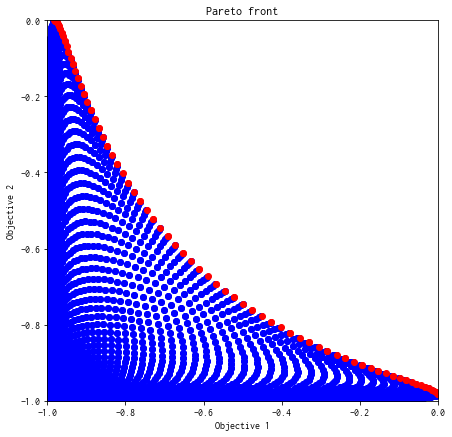

In [28]:
plot_pareto_front(res_all)

#### 劣解領域体積

In [29]:
res_all.pareto.volume_in_dominance([-1,-1],[0,0])

0.3345179057768165